In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 73.4 MB/s eta 0:00:00


In [ ]:
import os
import gc
import json
import math
import torch
import faiss
import random
import datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image
from itertools import cycle
from google.colab import drive
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from transformers import AutoTokenizer, AutoModel, AutoImageProcessor

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA A100-SXM4-40GB


Loading Datasets

In [ ]:
stream = load_dataset(
    "ituperceptron/image-captioning-turkish",
    split="long_captions",
    streaming=True
)
stream = stream.shuffle(buffer_size=10_000, seed=42)
subset_iter = stream.take(60000)

def gen():
    for ex in subset_iter:
        yield ex

img_txt_ds = datasets.Dataset.from_generator(gen, features=stream.features)

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
txt_txt_ds = load_dataset("dogukanvzr/ml-paraphrase-tr")

Dataset Wrappers

In [ ]:
class ImageTextDataset(Dataset):
    def __init__(self, hf_dataset):
        self.ds = hf_dataset

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = ex["image"]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        img = img.convert("RGB")
        return {"image": img, "text": ex["text"]}

In [ ]:
class TextTextDataset(Dataset):
    def __init__(self, hf_dataset):
        self.ds = hf_dataset.filter(lambda ex: ex["label"] == 1)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[idx]
        return {"s1": ex["sentence1"], "s2": ex["sentence2"]}

Encoders

In [ ]:
# Text Encoder
text_model_name = "newmindai/modernbert-base-tr-uncased-allnli-stsb"
tokenizer = AutoTokenizer.from_pretrained(text_model_name)
text_encoder = AutoModel.from_pretrained(text_model_name)

# Image Encoder
vision_model_name = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(vision_model_name)
vision_encoder = AutoModel.from_pretrained(vision_model_name)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Collate Functions

In [ ]:
def img_txt_collate(batch, max_length=128):
    texts  = [b["text"]  for b in batch]
    images = [b["image"] for b in batch]
    text_inputs = tokenizer(
        texts, return_tensors="pt", padding="longest",
        truncation=True, max_length=max_length
    )
    image_inputs = processor(images=images, return_tensors="pt")
    return text_inputs, image_inputs

def txt_txt_collate(batch, max_length=128):
    s1_list = [b["s1"] for b in batch]
    s2_list = [b["s2"] for b in batch]
    q_inputs = tokenizer(
        s1_list, return_tensors="pt", padding="longest",
        truncation=True, max_length=max_length
    )
    p_inputs = tokenizer(
        s2_list, return_tensors="pt", padding="longest",
        truncation=True, max_length=max_length
    )
    return q_inputs, p_inputs

Data Loaders

In [ ]:
BATCH_SIZE = 64

# Image-Text Dataset
base_img_txt = img_txt_ds
N = len(base_img_txt)
sample_img_txt = 45000
indices_img_txt = random.sample(range(N), sample_img_txt)

img_txt_train_size = int(0.7 * sample_img_txt)   # %70 train
img_txt_val_size   = int(0.2 * sample_img_txt)   # %20 validation
img_txt_test_size  = sample_img_txt - img_txt_train_size - img_txt_val_size # %10 test

img_txt_train_idx = indices_img_txt[:img_txt_train_size]
img_txt_val_idx = indices_img_txt[img_txt_train_size:img_txt_train_size + img_txt_val_size]
img_txt_test_idx = indices_img_txt[img_txt_train_size + img_txt_val_size:]

it_train = base_img_txt.select(img_txt_train_idx)
it_val = base_img_txt.select(img_txt_val_idx)
it_test = base_img_txt.select(img_txt_test_idx)

img_txt_train = ImageTextDataset(it_train)
img_txt_val = ImageTextDataset(it_val)
img_txt_test = ImageTextDataset(it_test)

# Text-Text Dataset
base_txt_txt = txt_txt_ds['train']
N = len(base_txt_txt)
sample_txt_txt = N
indices_txt_txt = random.sample(range(N), sample_txt_txt)

txt_txt_train_size = int(0.7 * sample_txt_txt)   # %70 train
txt_txt_val_size   = int(0.2 * sample_txt_txt)   # %20 validation
txt_txt_test_size  = sample_txt_txt - txt_txt_train_size - txt_txt_val_size # %10 test

txt_txt_train_idx = indices_txt_txt[:txt_txt_train_size]
txt_txt_val_idx = indices_txt_txt[txt_txt_train_size:txt_txt_train_size + txt_txt_val_size]
txt_txt_test_idx = indices_txt_txt[txt_txt_train_size + txt_txt_val_size:]

tt_train = base_txt_txt.select(txt_txt_train_idx)
tt_val = base_txt_txt.select(txt_txt_val_idx)
tt_test = base_txt_txt.select(txt_txt_test_idx)

txt_txt_train = TextTextDataset(tt_train)
txt_txt_val = TextTextDataset(tt_val)
txt_txt_test = TextTextDataset(tt_test)

# Loaders
dl_kwargs_train = dict(
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=2,              # paralel workers
    pin_memory=True,            # GPU için hızlı kopya
    persistent_workers=True,    # epoch sonrası worker kapanmaz
    prefetch_factor=2          # her worker 2 batch önden hazırlar
)

dl_kwargs_eval = dict(
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

img_txt_train_loader = DataLoader(img_txt_train, collate_fn=img_txt_collate, **dl_kwargs_train)
img_txt_val_loader = DataLoader(img_txt_val, collate_fn=img_txt_collate, **dl_kwargs_eval)
img_txt_test_loader = DataLoader(img_txt_test, collate_fn=img_txt_collate, **dl_kwargs_eval)

txt_txt_train_loader = DataLoader(txt_txt_train, collate_fn=txt_txt_collate, **dl_kwargs_train)
txt_txt_val_loader = DataLoader(txt_txt_val, collate_fn=txt_txt_collate, **dl_kwargs_eval)
txt_txt_test_loader = DataLoader(txt_txt_test, collate_fn=txt_txt_collate, **dl_kwargs_eval)

Filter:   0%|          | 0/42000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [ ]:
print(f"Image-Text Dataset: \ntrain: {len(img_txt_train)}, val: {len(img_txt_val)}, test: {len(img_txt_test)}")
print(f"Toplam: {len(img_txt_train) + len(img_txt_val) + len(img_txt_test)}")
print()
print(f"Text-Text Dataset: \ntrain: {len(txt_txt_train)}, val: {len(txt_txt_val)}, test: {len(txt_txt_test)}")
print(f"Toplam: {len(txt_txt_train) + len(txt_txt_val) + len(txt_txt_test)}")

Image-Text Dataset: 
train: 31499, val: 9000, test: 4501
Toplam: 45000

Text-Text Dataset: 
train: 31496, val: 8990, test: 4513
Toplam: 44999


Model Structure

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_mult=2, p_drop=0.1):
        super().__init__()
        h = int(hidden_mult * out_dim)
        self.net = nn.Sequential(
            nn.Linear(in_dim, h),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Linear(h, out_dim),
        )
        self.ln = nn.LayerNorm(out_dim)   # çıkış stabilizasyonu

        # Residual köprü (in_dim == out_dim ise)
        self.use_residual = (in_dim == out_dim)

    def forward(self, x):
        y = self.net(x)
        if self.use_residual:
            y = y + x
        return self.ln(y)

def masked_mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
    sum_embeddings = (last_hidden_state * mask).sum(dim=1)
    lengths = mask.sum(dim=1).clamp(min=1e-6)
    return sum_embeddings / lengths

class MultiModalEmbedder(nn.Module):
    def __init__(
        self,
        text_encoder,
        vision_encoder,
        text_dim: int = 768,
        image_dim: int = 768,
        embed_dim: int = 384,
        temperature_init: float = 1/0.07,
        use_mean_pooling_for_text: bool = True,
        freeze_encoders: bool = True
    ):
        super().__init__()
        self.text_encoder = text_encoder
        self.vision_encoder = vision_encoder
        self.embed_dim = embed_dim
        self.use_mean_pooling_for_text = use_mean_pooling_for_text

        # Projection heads
        self.text_proj = ProjectionHead(text_dim, embed_dim)
        self.image_proj = ProjectionHead(image_dim, embed_dim)

        # Learnable logit scale
        self.logit_scale = nn.Parameter(torch.tensor(math.log(temperature_init), dtype=torch.float))

        if freeze_encoders:
            for p in self.text_encoder.parameters():   p.requires_grad = False
            for p in self.vision_encoder.parameters(): p.requires_grad = False
        else:
            for p in self.text_encoder.parameters():   p.requires_grad = True
            for p in self.vision_encoder.parameters(): p.requires_grad = True

    def forward_text(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        if self.use_mean_pooling_for_text:
            pooled = masked_mean_pool(out.last_hidden_state, attention_mask)
        else:
            pooled = out.last_hidden_state[:, 0, :]
        return F.normalize(self.text_proj(pooled), dim=-1)

    def forward_image(self, pixel_values: torch.Tensor):
        out = self.vision_encoder(pixel_values=pixel_values, return_dict=True)
        cls = out.last_hidden_state[:, 0, :]
        return F.normalize(self.image_proj(cls), dim=-1)

    def forward(self, text_inputs: dict, image_inputs: dict):
        t = self.forward_text(text_inputs["input_ids"], text_inputs["attention_mask"])
        v = self.forward_image(image_inputs["pixel_values"])
        return t, v

Loss

In [ ]:
def bidir_contrastive_loss(a: torch.Tensor, b: torch.Tensor, logit_scale: torch.Tensor):
    scale = logit_scale.exp().clamp(max=100)   # aşırı büyümeyi engelle
    logits = (a @ b.T) * scale                 # (B, B)

    labels = torch.arange(a.size(0), device=a.device)
    loss_ab = F.cross_entropy(logits, labels)      # a -> b
    loss_ba = F.cross_entropy(logits.T, labels)    # b -> a
    return 0.5 * (loss_ab + loss_ba)

Metrics

In [ ]:
# Average Cosine Similarity
@torch.no_grad()
def average_cos_sim(embs_1: torch.Tensor, embs_2: torch.Tensor):
    similarities = F.cosine_similarity(embs_1, embs_2, dim=-1)
    return similarities.mean().item()

In [ ]:
# Recall@K
@torch.no_grad()
def recall_at_k_faiss(query_embs: torch.Tensor, gallery_embs: torch.Tensor, ks=(1,5,10)):
    """
    query_embs: (N, D) tensor  -> arama yapılan taraf (ör. text)
    gallery_embs: (N, D) tensor -> indekslenen taraf (ör. image)
    """
    Q = query_embs.float().cpu().numpy()
    G = gallery_embs.float().cpu().numpy()

    index = faiss.IndexFlatIP(G.shape[1])   # inner product (cosine için uygun, çünkü normalize edilmiş)
    index.add(G)
    D, I = index.search(Q, max(ks))         # en yakın komşuları bul

    N = Q.shape[0]
    recalls = {}
    for k in ks:
        hits = sum(1 for i in range(N) if i in I[i, :k])
        recalls[f"R@{k}"] = hits / float(N)
    return recalls

Train Function

In [ ]:
def train(
    model,
    img_txt_train_loader, txt_txt_train_loader,
    img_txt_val_loader,   txt_txt_val_loader,
    optimizer, device, run_name,
    epochs=5,
    lambda_imgtxt=1.0, lambda_txttxt=1.0,
    text_model_name="(text-encoder)",
    vision_model_name="(vision-encoder)",
    project_name="multimodal-embedding-runs-jina",
    freeze_encoders=True
):
    config={
            "epochs": epochs,
            "img_txt_batch_size": img_txt_train_loader.batch_size,
            "txt_txt_batch_size": txt_txt_train_loader.batch_size,
            "learning_rate": optimizer.param_groups[0]['lr'],
            "optimizer": "AdamW",
            "embed_dim": model.embed_dim,
            "text_encoder": text_model_name,
            "vision_encoder": vision_model_name,
            "lambda_imgtxt": lambda_imgtxt,
            "lambda_txttxt": lambda_txttxt,
    }
    os.makedirs("run_configs", exist_ok=True)
    with open(os.path.join("run_configs", run_name), "w") as f:
        json.dump(config, f, indent=4)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # TRAIN
        model.train()

        if freeze_encoders:
          model.text_encoder.eval()
          model.vision_encoder.eval()

        steps = min(len(img_txt_train_loader), len(txt_txt_train_loader))

        tr_total_sum = 0.0

        train_text_embs_imgtxt = []
        train_image_embs_imgtxt = []
        train_q_embs_txttxt    = []
        train_p_embs_txttxt    = []

        for (img_batch, tt_batch) in zip(img_txt_train_loader, txt_txt_train_loader):
            # img_batch: (text_inputs, image_inputs)
            # tt_batch : (query_inputs, pos_inputs)
            text_inputs, image_inputs = img_batch
            q_inputs,    p_inputs    = tt_batch

            text_inputs = {k: v.to(device, non_blocking=True) for k, v in text_inputs.items()}
            image_inputs = {k: v.to(device, non_blocking=True) for k, v in image_inputs.items()}
            q_inputs     = {k: v.to(device, non_blocking=True) for k, v in q_inputs.items()}
            p_inputs     = {k: v.to(device, non_blocking=True) for k, v in p_inputs.items()}

            optimizer.zero_grad(set_to_none=True)

            # Image–Text
            t_imgtxt, v_imgtxt = model(text_inputs, image_inputs)
            loss_imgtxt = bidir_contrastive_loss(t_imgtxt, v_imgtxt, model.logit_scale)

            # Text–Text
            q_emb = model.forward_text(q_inputs["input_ids"], q_inputs["attention_mask"])
            p_emb = model.forward_text(p_inputs["input_ids"], p_inputs["attention_mask"])
            loss_txttxt = bidir_contrastive_loss(q_emb, p_emb, model.logit_scale)

            # Joint
            total_loss = lambda_imgtxt * loss_imgtxt + lambda_txttxt * loss_txttxt
            total_loss.backward()
            optimizer.step()

            tr_total_sum += total_loss.item()

            # metri̇kler için biriktir
            train_text_embs_imgtxt.append(t_imgtxt.detach().cpu())
            train_image_embs_imgtxt.append(v_imgtxt.detach().cpu())
            train_q_embs_txttxt.append(q_emb.detach().cpu())
            train_p_embs_txttxt.append(p_emb.detach().cpu())

        # concat train embeddings
        train_text_embs_imgtxt = torch.cat(train_text_embs_imgtxt, dim=0)
        train_image_embs_imgtxt = torch.cat(train_image_embs_imgtxt, dim=0)
        train_q_embs_txttxt = torch.cat(train_q_embs_txttxt, dim=0)
        train_p_embs_txttxt = torch.cat(train_p_embs_txttxt, dim=0)

        avg_tr_total  = tr_total_sum  / max(1, steps)
        train_losses.append(avg_tr_total)

        train_recall_at_k = recall_at_k_faiss(train_image_embs_imgtxt, train_text_embs_imgtxt)
        train_avg_sim = average_cos_sim(train_image_embs_imgtxt, train_text_embs_imgtxt)

        # VALIDATION
        model.eval()
        with torch.no_grad():
            vsteps = min(len(img_txt_val_loader), len(txt_txt_val_loader))

            val_total_sum = 0.0

            val_text_embs_imgtxt = []
            val_image_embs_imgtxt = []
            val_q_embs_txttxt = []
            val_p_embs_txttxt = []

            for (img_batch, tt_batch) in zip(img_txt_val_loader, txt_txt_val_loader):
                text_inputs, image_inputs = img_batch
                q_inputs,    p_inputs    = tt_batch

                text_inputs = {k: v.to(device, non_blocking=True) for k, v in text_inputs.items()}
                image_inputs = {k: v.to(device, non_blocking=True) for k, v in image_inputs.items()}
                q_inputs     = {k: v.to(device, non_blocking=True) for k, v in q_inputs.items()}
                p_inputs     = {k: v.to(device, non_blocking=True) for k, v in p_inputs.items()}

                # Image–Text
                t_imgtxt, v_imgtxt = model(text_inputs, image_inputs)
                loss_imgtxt = bidir_contrastive_loss(t_imgtxt, v_imgtxt, model.logit_scale)

                # Text–Text
                q_emb = model.forward_text(q_inputs["input_ids"], q_inputs["attention_mask"])
                p_emb = model.forward_text(p_inputs["input_ids"], p_inputs["attention_mask"])
                loss_txttxt = bidir_contrastive_loss(q_emb, p_emb, model.logit_scale)

                total_loss = lambda_imgtxt * loss_imgtxt + lambda_txttxt * loss_txttxt

                val_total_sum += total_loss.item()

                val_text_embs_imgtxt.append(t_imgtxt.detach().cpu())
                val_image_embs_imgtxt.append(v_imgtxt.detach().cpu())
                val_q_embs_txttxt.append(q_emb.detach().cpu())
                val_p_embs_txttxt.append(p_emb.detach().cpu())

            # concat val embeddings
            val_text_embs_imgtxt = torch.cat(val_text_embs_imgtxt, dim=0)
            val_image_embs_imgtxt = torch.cat(val_image_embs_imgtxt, dim=0)
            val_q_embs_txttxt = torch.cat(val_q_embs_txttxt, dim=0)
            val_p_embs_txttxt = torch.cat(val_p_embs_txttxt, dim=0)

            avg_val_total  = val_total_sum  / max(1, vsteps)
            val_losses.append(avg_val_total)

            val_recall_at_k = recall_at_k_faiss(val_image_embs_imgtxt, val_text_embs_imgtxt)
            vall_avg_sim = average_cos_sim(val_image_embs_imgtxt, val_text_embs_imgtxt)

        print(
            f"Epoch {epoch+1} -> train_loss: {avg_tr_total:.4f}, "
            f"train_avg_sim: {train_avg_sim:.4f}, "
            f"train_recall_1: {train_recall_at_k['R@1']:.4f} | "
            f"val_loss: {avg_val_total:.4f}, "
            f"val_avg_sim: {vall_avg_sim:.4f}, "
            f"val_recall_1: {val_recall_at_k['R@1']:.4f}"
        )
    return train_losses, val_losses

Define Model and Train

In [ ]:
FREEZE_ENCODERS = False

In [ ]:
model = MultiModalEmbedder(text_encoder,
                           vision_encoder,
                           text_dim=768,
                           image_dim=768,
                           embed_dim=768,
                           freeze_encoders=FREEZE_ENCODERS).to(device)
if FREEZE_ENCODERS:
    optimizer = torch.optim.AdamW(
        list(model.text_proj.parameters()) + list(model.image_proj.parameters()) + [model.logit_scale],
        lr=1e-3
    )
else:
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [ ]:
# Trainable Parameters
def count_parameters(model, print_layers=False):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Toplam parametre sayısı: {total:,}")
    print(f"Eğitilebilir parametre sayısı: {trainable:,}")
    print(f"Donmuş (freeze) parametre sayısı: {total - trainable:,}")
    if print_layers:
      print("\n--- Trainable katmanlar ---")
      for name, p in model.named_parameters():
          if p.requires_grad:
              print(f"{name:60s} {p.numel():,}")
count_parameters(model)

Toplam parametre sayısı: 226,214,401
Eğitilebilir parametre sayısı: 226,214,401
Donmuş (freeze) parametre sayısı: 0


In [ ]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
train_losses, val_losses = train(
    model,
    img_txt_train_loader, txt_txt_train_loader,
    img_txt_val_loader,   txt_txt_val_loader,
    optimizer, torch.device("cuda"), run_name=f"jina_run_2_gelu",
    epochs=10,
    lambda_imgtxt=1.0, lambda_txttxt=1.0,
    text_model_name=text_model_name,
    vision_model_name=vision_model_name,
    freeze_encoders=FREEZE_ENCODERS
)

/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:282: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


Epoch 1 -> train_loss: 1.0928, train_avg_sim: 0.5092, train_recall_1: 0.1395 | val_loss: 0.5016, val_avg_sim: 0.6389, val_recall_1: 0.4077
Epoch 2 -> train_loss: 0.3615, train_avg_sim: 0.6795, train_recall_1: 0.3661 | val_loss: 0.3552, val_avg_sim: 0.6885, val_recall_1: 0.5401
Epoch 3 -> train_loss: 0.2483, train_avg_sim: 0.7167, train_recall_1: 0.5164 | val_loss: 0.3058, val_avg_sim: 0.7076, val_recall_1: 0.5926
Epoch 4 -> train_loss: 0.1902, train_avg_sim: 0.7389, train_recall_1: 0.6133 | val_loss: 0.2784, val_avg_sim: 0.7207, val_recall_1: 0.6179
Epoch 5 -> train_loss: 0.1533, train_avg_sim: 0.7538, train_recall_1: 0.6879 | val_loss: 0.2546, val_avg_sim: 0.7327, val_recall_1: 0.6710
Epoch 6 -> train_loss: 0.1287, train_avg_sim: 0.7647, train_recall_1: 0.7413 | val_loss: 0.2467, val_avg_sim: 0.7342, val_recall_1: 0.6763
Epoch 7 -> train_loss: 0.1131, train_avg_sim: 0.7735, train_recall_1: 0.7824 | val_loss: 0.2428, val_avg_sim: 0.7336, val_recall_1: 0.6756
Epoch 8 -> train_loss: 0.09

Plot Train-Val Loss

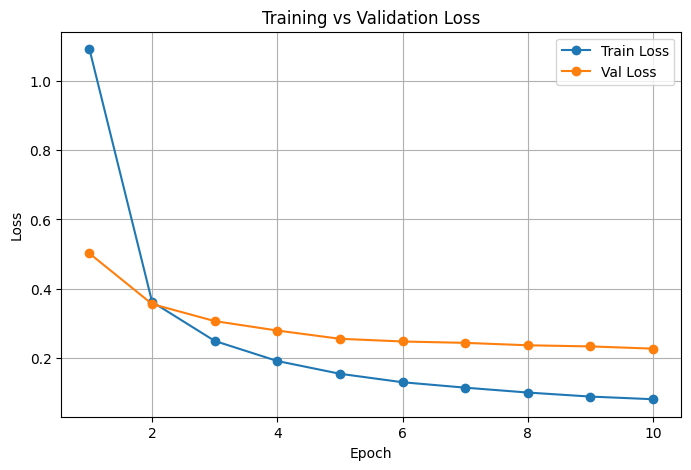

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Val Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

Save Plot

In [ ]:
plt.savefig("/content/drive/MyDrive/loss_plot_jina_run_1_gelu.png")

<Figure size 640x480 with 0 Axes>

Save Model

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/multimodal_embedding_jina.pth")